In [7]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from collections import Counter
from catboost import CatBoostRegressor

In [71]:
load = pd.read_csv('main_train.csv')
x = load.iloc[:, :-1]
y = load.iloc[:, -1]
x = x[['Shrt_Desc', 'Protein_(g)', 'Lipid_Tot_(g)', 'Carbohydrt_(g)']]
x.head()

,Shrt_Desc,Protein_(g),Lipid_Tot_(g),Carbohydrt_(g)
0,"BABYFOOD,CRL,OATMEAL,W/BANANAS,DRY",12.00,6.00,73.40
1,"HEARTS OF PALM,CANNED",2.52,0.62,4.62
2,"CHICKEN,BROILERS OR FRYERS,THIGH,MEAT ONLY,CKD...",24.06,11.09,0.00
3,"PORK,CURED,SHLDR,ARM PICNIC,LN&FAT,RSTD",20.43,21.35,0.00
4,"VINEGAR,DISTILLED",0.00,0.00,0.04


# Попробуем закодировать названия с помощью one-hot кодирования

In [3]:
names = x.Shrt_Desc.values
names = Counter([j  for i in names for j in i.split(',') ])
d = {'word': list(names.keys()), 'count': list(names.values())}

In [59]:
analise_desc = pd.DataFrame.from_dict(d)
analise_desc = analise_desc.loc[1:]
analise_desc = analise_desc.sort_values(by='count', ascending=False).reset_index(drop=True)
analise_desc.head()

,count,word
0,1470,CKD
1,1151,RAW
2,838,BEEF
3,574,LN
4,436,CND


Оставим только часто повторяющиеся значения

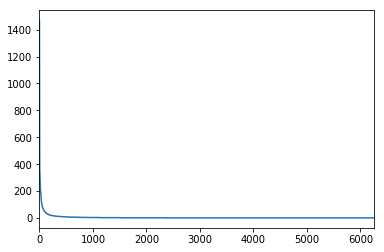

In [40]:
analise_desc['count'].plot()

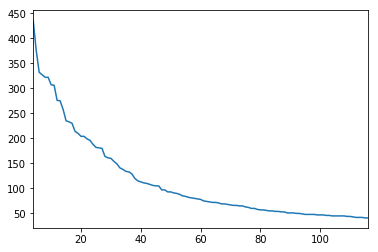

In [50]:
analise_desc.loc[analise_desc['count'] < 500]['count'].plot()

In [62]:
analise_desc_sh = analise_desc.loc[analise_desc['count'] > 100]

In [64]:
new_col = analise_desc_sh.word.values

In [67]:
x.Shrt_Desc.values
new_data = pd.DataFrame(columns=new_col)
n = 0
for i in x.Shrt_Desc.values:
    new_data.loc[n] = [i.find(j) != -1 for j in new_col]
    n += 1
new_data.head()

,CKD,RAW,BEEF,LN,CND,LN & FAT,"0"" FAT",PORK,FRZ,BLD,...,WHITE,FAST FOODS,CANDIES,KEEBLER,BONE-IN,COND,DRY MIX,CURED,BROILERS OR FRYERS,BEANS
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [72]:
new_train = x.join(new_data)
new_train.head()

,Shrt_Desc,Protein_(g),Lipid_Tot_(g),Carbohydrt_(g),CKD,RAW,BEEF,LN,CND,LN & FAT,...,WHITE,FAST FOODS,CANDIES,KEEBLER,BONE-IN,COND,DRY MIX,CURED,BROILERS OR FRYERS,BEANS
0,"BABYFOOD,CRL,OATMEAL,W/BANANAS,DRY",12.00,6.00,73.40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"HEARTS OF PALM,CANNED",2.52,0.62,4.62,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"CHICKEN,BROILERS OR FRYERS,THIGH,MEAT ONLY,CKD...",24.06,11.09,0.00,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,"PORK,CURED,SHLDR,ARM PICNIC,LN&FAT,RSTD",20.43,21.35,0.00,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,"VINEGAR,DISTILLED",0.00,0.00,0.04,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [73]:
new_train.to_csv('train_2.csv')

In [84]:
new_train = new_train.iloc[:, 1:]
test_size = round(y.size * 0.3)
test_data = new_train.sample(test_size)
train_data = new_train.drop(new_train.sample(test_size).index, axis=0)
test_y = y[test_data.index].to_numpy()
train_y = y[train_data.index].to_numpy()

# Проверим важность признаков с помощью catboost

In [87]:
catboost_reg = CatBoostRegressor(iterations=200, loss_function='MAE', depth=10, learning_rate=0.03, l2_leaf_reg=3)
catboost_reg = catboost_reg.fit(train_data, train_y, verbose=False)

In [88]:
sum(abs(catboost_reg.predict(test_data) - test_y)) / test_y.size

12.125687674030514

In [89]:
feature_importance = catboost_reg.get_feature_importance()
features = catboost_reg.feature_names_
deleted = []

for feature_id in feature_importance.argsort()[::-1]:
    name = features[feature_id]
    importance = feature_importance[feature_id]
    if importance < 1.1:
        deleted.append(name)
    print(name, importance)
deleted

Lipid_Tot_(g) 47.6143809405047
Carbohydrt_(g) 25.60765456427822
Protein_(g) 21.29193311005375
CKD 0.8163755155433814
DRY 0.46751104539602856
RND 0.4423566330138976
W/SALT 0.3938186756954572
KEEBLER 0.35304443921802875
SOUP 0.29165366393886655
CANDIES 0.28912676779446617
RAW 0.2418396431629991
FRZ 0.22457152163694105
WO/SALT 0.21062097481723233
CEREALS RTE 0.20592262701487996
LN 0.18503125221774142
CND 0.16382181021817244
COND 0.15237839721531665
BABYFOOD 0.14302861615402318
BEEF 0.1242247034101834
DRND 0.10682378339320592
LN&FAT 0.08936377134493967
UNPREP 0.08468790185747874
MATURE SEEDS 0.07267341388116601
DRY MIX 0.05524550963329094
BLD 0.053301395272766214
WHITE 0.03905311784212595
BNLESS 0.03728850848438124
CHICKEN 0.02845052155878161
BROILERS OR FRYERS 0.02486019509009673
NZ 0.02470011426267081
LAMB 0.02381973082719258
FAST FOODS 0.022206346916968243
PORK 0.020228011996079955
RSTD 0.018794744575929157
0" FAT 0.013056464907117694
SEL 0.012471386113557916
CURED 0.012366390608995694


['CKD',
 'DRY',
 'RND',
 'W/SALT',
 'KEEBLER',
 'SOUP',
 'CANDIES',
 'RAW',
 'FRZ',
 'WO/SALT',
 'CEREALS RTE',
 'LN',
 'CND',
 'COND',
 'BABYFOOD',
 'BEEF',
 'DRND',
 'LN&FAT',
 'UNPREP',
 'MATURE SEEDS',
 'DRY MIX',
 'BLD',
 'WHITE',
 'BNLESS',
 'CHICKEN',
 'BROILERS OR FRYERS',
 'NZ',
 'LAMB',
 'FAST FOODS',
 'PORK',
 'RSTD',
 '0" FAT',
 'SEL',
 'CURED',
 'BRSD',
 'LOIN',
 '1/8" FAT',
 'LN & FAT',
 'IMP',
 'BRLD',
 'FRSH',
 'CHOIC',
 'BEANS',
 'MEAT ONLY',
 'BONE-IN',
 'ALL GRDS',
 '1/8"FAT']

### Как мы видим категории очень слабо влияют на нашу модель, поэтому их можно убрать

In [73]:
x = load.iloc[:, :-1]
x = x[['Protein_(g)', 'Lipid_Tot_(g)', 'Carbohydrt_(g)']]
x.head()

,Protein_(g),Lipid_Tot_(g),Carbohydrt_(g)
0,12.00,6.00,73.40
1,2.52,0.62,4.62
2,24.06,11.09,0.00
3,20.43,21.35,0.00
4,0.00,0.00,0.04


In [74]:
col = ['Protein_(g)', 'Lipid_Tot_(g)', 'Carbohydrt_(g)']
poly_features = x
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=3)
poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)
poly_transformer.get_feature_names(input_features = col)[:15]
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(col))
poly_features['Energ_Kcal'] = y
corr = poly_features.corr()['Energ_Kcal'].sort_values()
print(corr.head(10))
print(corr.tail(10))

Protein_(g)^3                   0.054110
Protein_(g)^2                   0.066414
Protein_(g)                     0.112094
Protein_(g)^2 Carbohydrt_(g)    0.253569
Protein_(g)^2 Lipid_Tot_(g)     0.263043
Protein_(g) Lipid_Tot_(g)       0.410160
Protein_(g) Lipid_Tot_(g)^2     0.426355
Protein_(g) Carbohydrt_(g)^2    0.449024
Carbohydrt_(g)^3                0.450500
Protein_(g) Carbohydrt_(g)      0.460681
Name: Energ_Kcal, dtype: float64
Carbohydrt_(g)^2                            0.490147
Lipid_Tot_(g)^2 Carbohydrt_(g)              0.552829
Protein_(g) Lipid_Tot_(g) Carbohydrt_(g)    0.560885
Lipid_Tot_(g) Carbohydrt_(g)^2              0.561593
Lipid_Tot_(g)^3                             0.578063
Lipid_Tot_(g) Carbohydrt_(g)                0.603304
Lipid_Tot_(g)^2                             0.663735
Lipid_Tot_(g)                               0.809028
Energ_Kcal                                  1.000000
1                                                NaN
Name: Energ_Kcal, dtype: fl

In [75]:
poly_features = poly_features.drop(['Energ_Kcal'], axis=1)

In [76]:
test_size = round(y.size * 0.3)
test_data_pol = poly_features.sample(test_size)
train_data_pol = poly_features.drop(poly_features.sample(test_size).index, axis=0)
test_y = y[test_data.index].to_numpy()
train_y = y[train_data.index].to_numpy()

In [77]:
train_data = train_data_pol[col]
test_data = test_data_pol[col]

## Linear regression

In [78]:
lin_reg = LinearRegression().fit(train_data_pol, train_y)

In [79]:
sum(abs(np.round(lin_reg.predict(test_data_pol)) - test_y))/ test_y.size

135.3308981521272

In [89]:
lin = LinearRegression().fit(train_data.to_numpy(), train_y)

In [90]:
sum(abs(lin.predict(test_data.to_numpy()) - test_y)) / test_y.size

135.39075442331904

## Catboost

In [36]:
grid_search_cb = pd.DataFrame(columns=['test_mae', 'train_mae', 'learning_rate', 'depth', 'regularization'])
learning_rate = [0.01, 0.03, 0.1, 0.3]
depth = [4, 6, 8, 10, 12]
l2_leaf_reg = [1, 3, 5, 7, 9]
n = 0
for lr in learning_rate:
    for d in depth:
        for l in l2_leaf_reg:
            print(n)
            m = CatBoostRegressor(iterations=1000, loss_function='MAE', depth=d, learning_rate=lr, l2_leaf_reg=l)
            m = m.fit(train_data, train_y, verbose=False)
            grid_search_cb.loc[n] = [sum(abs(m.predict(test_data) - test_y)) / test_y.size, sum(abs(m.predict(train_data) - train_y)) / train_y.size, lr, d, l]
            n += 1
grid_search_cb.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


,test_mae,train_mae,learning_rate,depth,regularization
0,11.400278,12.227124,0.01,4.0,1.0
1,11.380327,12.223712,0.01,4.0,3.0
2,11.474107,12.306954,0.01,4.0,5.0
3,11.397169,12.248079,0.01,4.0,7.0
4,11.521692,12.358779,0.01,4.0,9.0


In [38]:
grid_search_cb.sort_values(by='test_mae').head()

,test_mae,train_mae,learning_rate,depth,regularization
98,3.554734,2.648043,0.3,12.0,7.0
95,3.575702,2.555113,0.3,12.0,1.0
99,3.586188,2.547097,0.3,12.0,9.0
96,3.643039,2.541846,0.3,12.0,3.0
97,3.659743,2.528672,0.3,12.0,5.0


## Random Forest

In [42]:
grid_search_randfor = pd.DataFrame(columns=['test_mae', 'train_mae', 'estimators', 'depth'])
estimators = [100, 200, 50]
depth = [5, 8, 10, None]
n = 0
for est in estimators:
    for d in depth:
        print(n)
        m = RandomForestRegressor(n_estimators=est, max_depth=d, criterion='mae').fit(train_data, train_y)
        grid_search_randfor.loc[n] = [sum(abs(m.predict(test_data) - test_y)) / test_y.size, sum(abs(m.predict(train_data) - train_y)) / train_y.size, est, d]
        n += 1
grid_search_randfor.head()

0
1
2
3
4
5
6
7
8
9
10
11


,test_mae,train_mae,estimators,depth
0,18.340945,18.061864,100.0,5.0
1,9.059643,8.982477,100.0,8.0
2,6.400587,6.090204,100.0,10.0
3,4.052843,3.246620,100.0,NaN
4,18.139505,17.952257,200.0,5.0


In [43]:
grid_search_randfor.sort_values(by='test_mae')

,test_mae,train_mae,estimators,depth
7,3.998745,3.208910,200.0,NaN
3,4.052843,3.246620,100.0,NaN
11,4.148578,3.286552,50.0,NaN
10,6.350232,6.061044,50.0,10.0
6,6.397892,6.033540,200.0,10.0
2,6.400587,6.090204,100.0,10.0
5,9.003915,8.893339,200.0,8.0
9,9.048668,8.892704,50.0,8.0
1,9.059643,8.982477,100.0,8.0
4,18.139505,17.952257,200.0,5.0


In [ ]:
grid_search_randfor = pd.DataFrame(columns=['test_mae', 'train_mae', 'estimators', 'depth'])
estimators = [100, 200, 50]
depth = [5, 8, 10, None]
n = 0
for est in estimators:
    for d in depth:
        print(n)
        m = RandomForestRegressor(n_estimators=est, max_depth=d, criterion='mae').fit(train_data_del, train_y)
        grid_search_randfor.loc[n] = [sum(abs(m.predict(test_data_del) - test_y)) / test_y.size, sum(abs(m.predict(train_data_del) - train_y)) / train_y.size, est, d]
        n += 1
grid_search_randfor.head()

# Предсказание

In [24]:
test = pd.read_csv('main_test.csv')
test = test[['Protein_(g)', 'Lipid_Tot_(g)', 'Carbohydrt_(g)']]
final_model = CatBoostRegressor(iterations=1000, loss_function='MAE', depth=12, learning_rate=0.3, l2_leaf_reg=7)
final_model = final_model.fit(x, y, verbose=False)
pkl_filename = './models/catboost.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(final_model, file)
final_res = np.round(final_model.predict(test)).astype(np.int64)
final_res = (final_res >= 0) * final_res
pd.DataFrame(final_res, columns=['Pred_kcal']).to_csv('Pred_main.csv', index=False)